In [1]:
# Import default libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters

# Import to ignore warnings 
import warnings
warnings.filterwarnings('ignore')

# Default params for all schemes 
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)
plt.style.use('ggplot')

In [16]:
# Convert the dataset into time series data by undating the index to time series index
df= pd.read_csv('NVDA_historical_data.csv', index_col='Date', parse_dates=True)

In [17]:
df = df.dropna()

In [18]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-10-22,57.820000,58.830002,56.767502,57.805000,57.303711,36884400
2018-10-23,55.107498,56.047501,54.177502,55.264999,54.785740,62643600
2018-10-24,54.877499,55.347500,49.712502,49.852501,49.420181,88428800
2018-10-25,48.867500,52.437500,48.419998,51.959999,51.509396,95172000
2018-10-26,49.577499,51.209999,48.279999,49.572498,49.142605,66478400


In [19]:
df.shape

(1008, 6)

In [20]:
df=df.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'])

In [21]:
df.head()

,Close
Date,
2018-10-22,57.805000
2018-10-23,55.264999
2018-10-24,49.852501
2018-10-25,51.959999
2018-10-26,49.572498


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1008 entries, 2018-10-22 to 2022-10-21
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1008 non-null   float64
dtypes: float64(1)
memory usage: 15.8 KB


<Axes: xlabel='Date'>

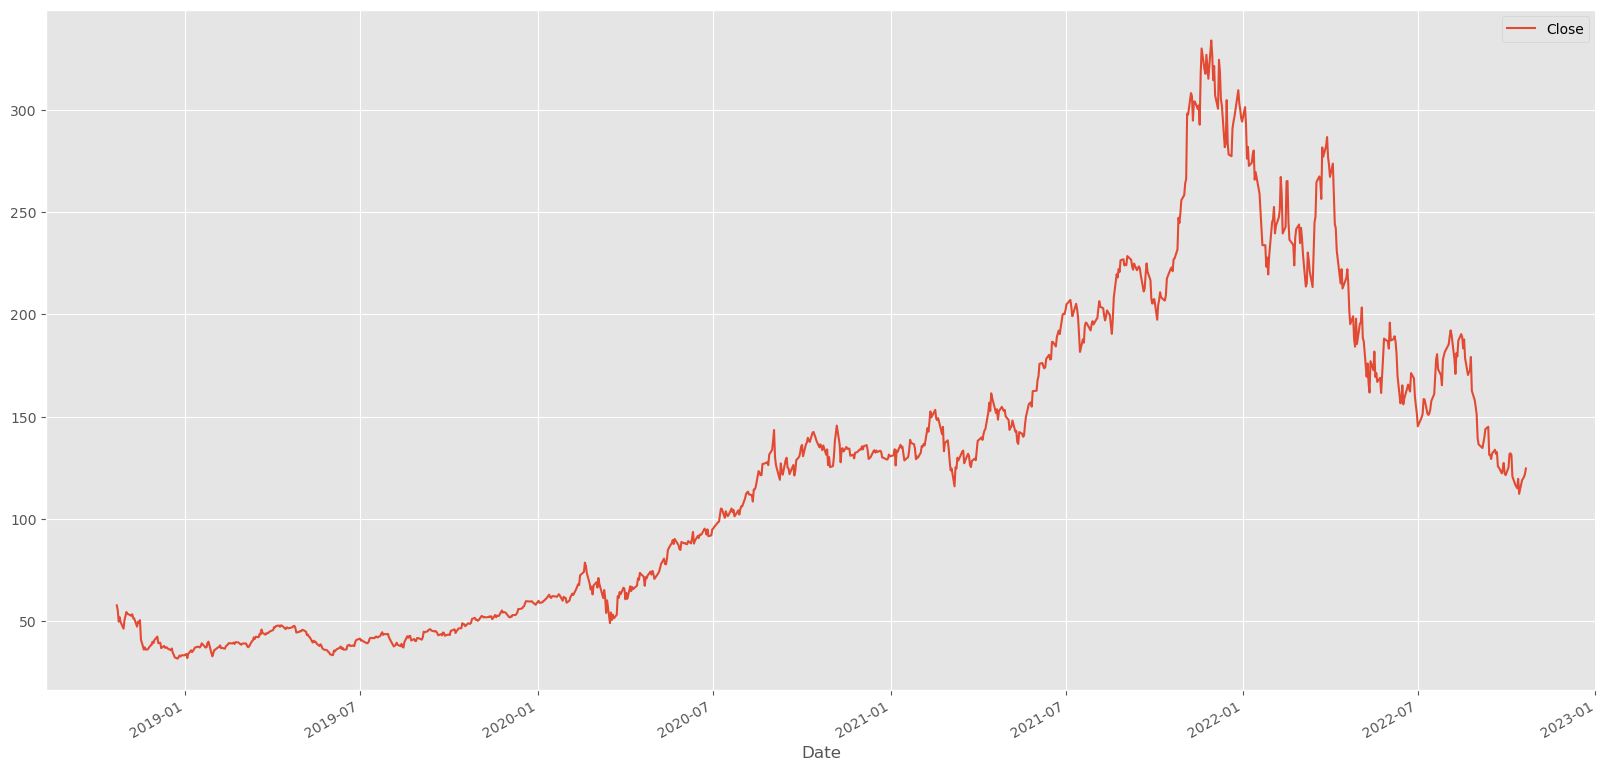

In [22]:
# Get a summary of the data 
df.info()
# Plot the data 
df.plot()

<Axes: xlabel='Date'>

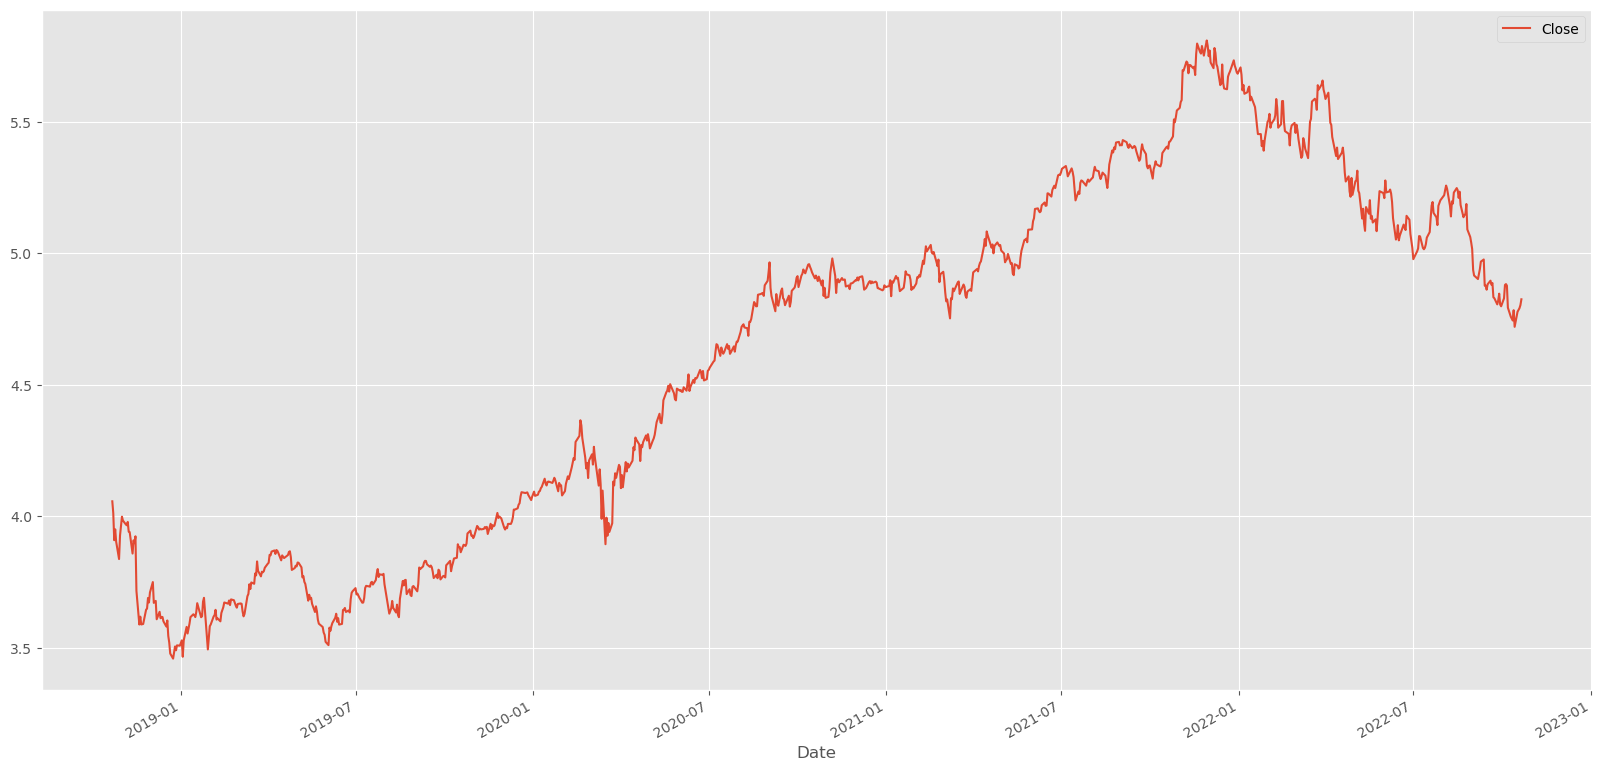

In [23]:
# take the log of values to stablisie variance by reducing the impact of extreme values 
df = np.log(df) 

df.plot()

In [24]:
#Split dataset into training set and testing set 
# Training set contains 80% of the data
df_train = df[0:806]
# Testing set contains the 20% of the data 
df_test = df[1800:]

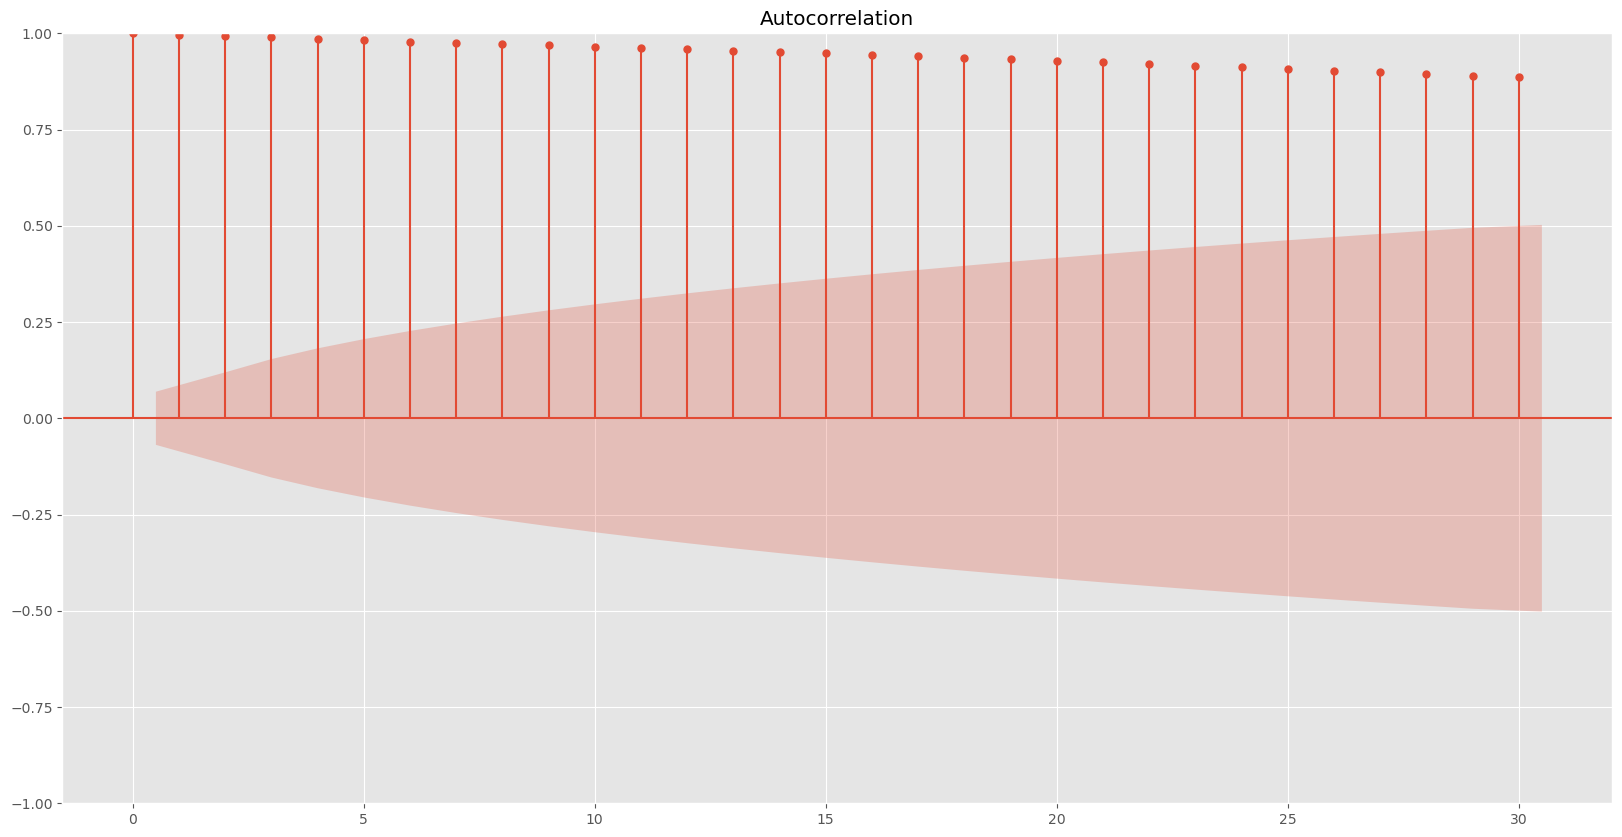

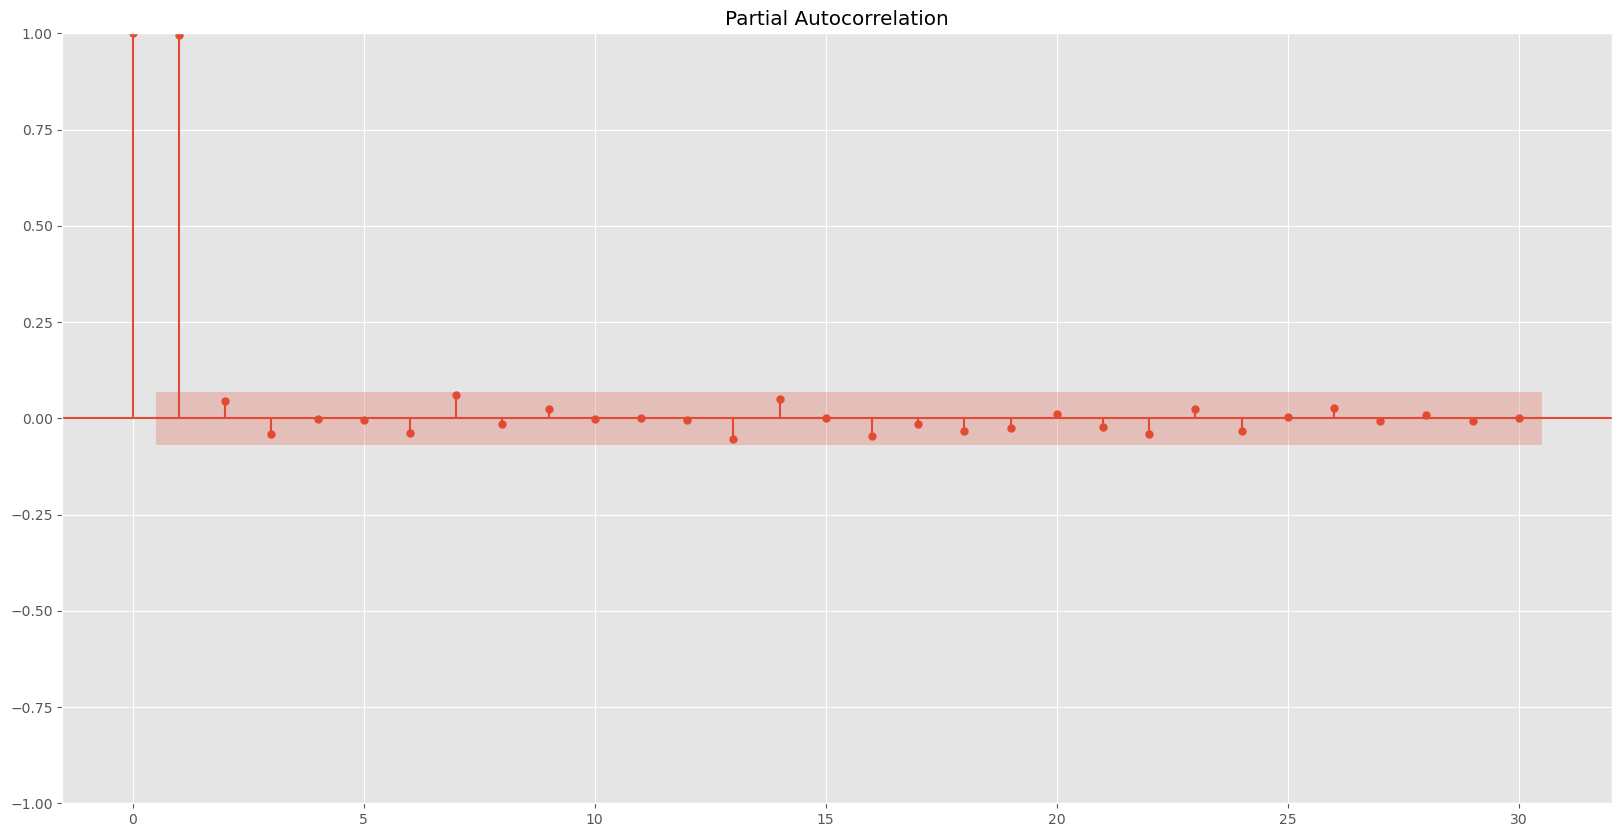

In [25]:
# Create autocorrelation and partial autocorrelation plot 
# Check for stationarity of time series 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_original = plot_acf(df_train)

pacf_original = plot_pacf(df_train)

In [26]:
# Use the Augmented Dicket Fuller test to calculate the p-value 
# Use the p-value to compare with the threshold of 0.5
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df_train)
print(f'p-value: {adf_test[1]}')
# It can clearly be observed that the p-value is greater than 0.05
# the data is not stationary

p-value: 0.9856060976884159


<Axes: xlabel='Date'>

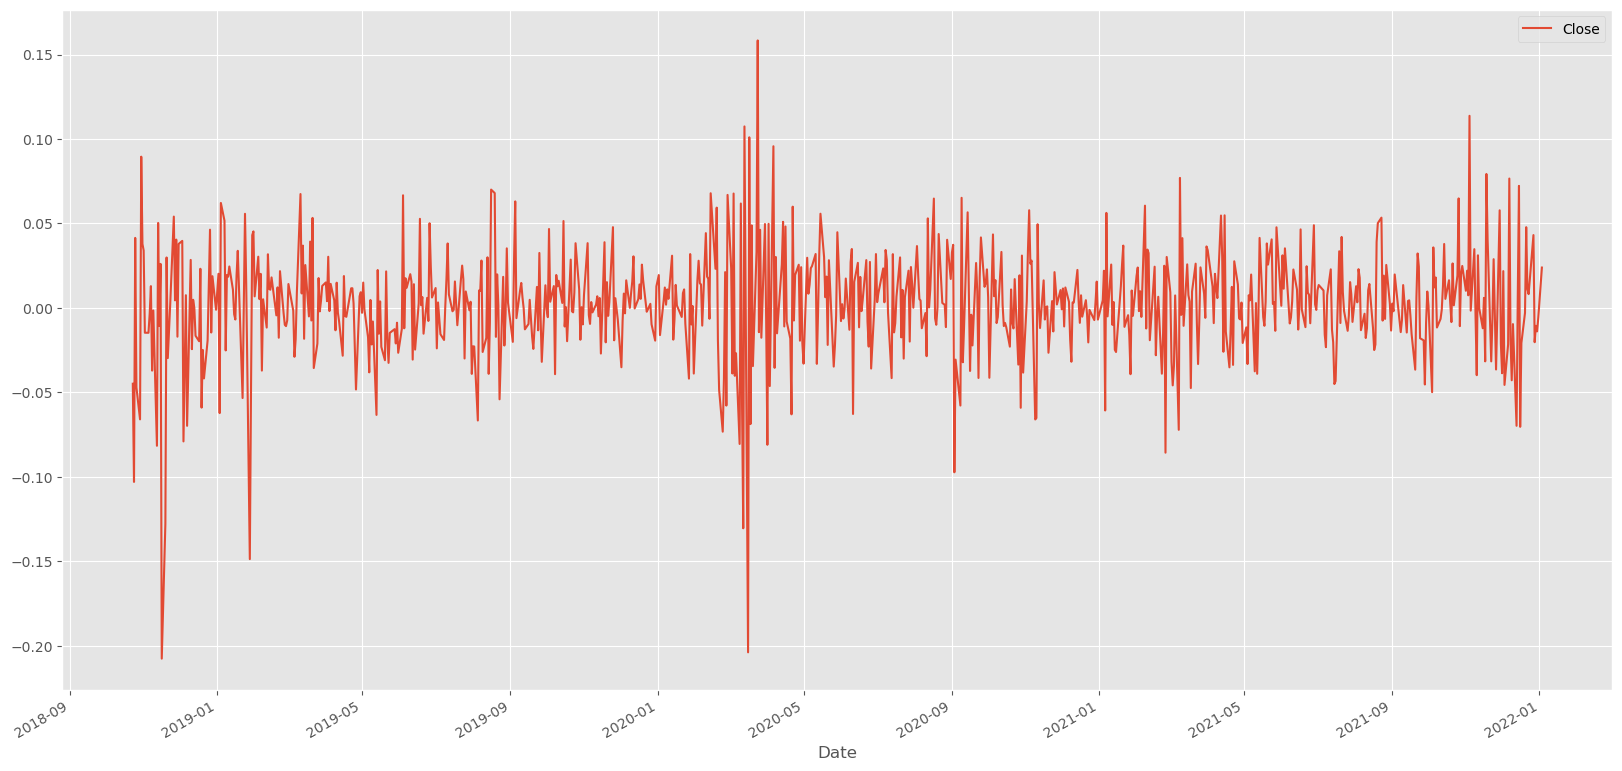

In [27]:
# Since the data is non-stationary, want to increment the differencing order by one 
df_train_diff = df_train.diff().dropna()
df_train_diff.plot()

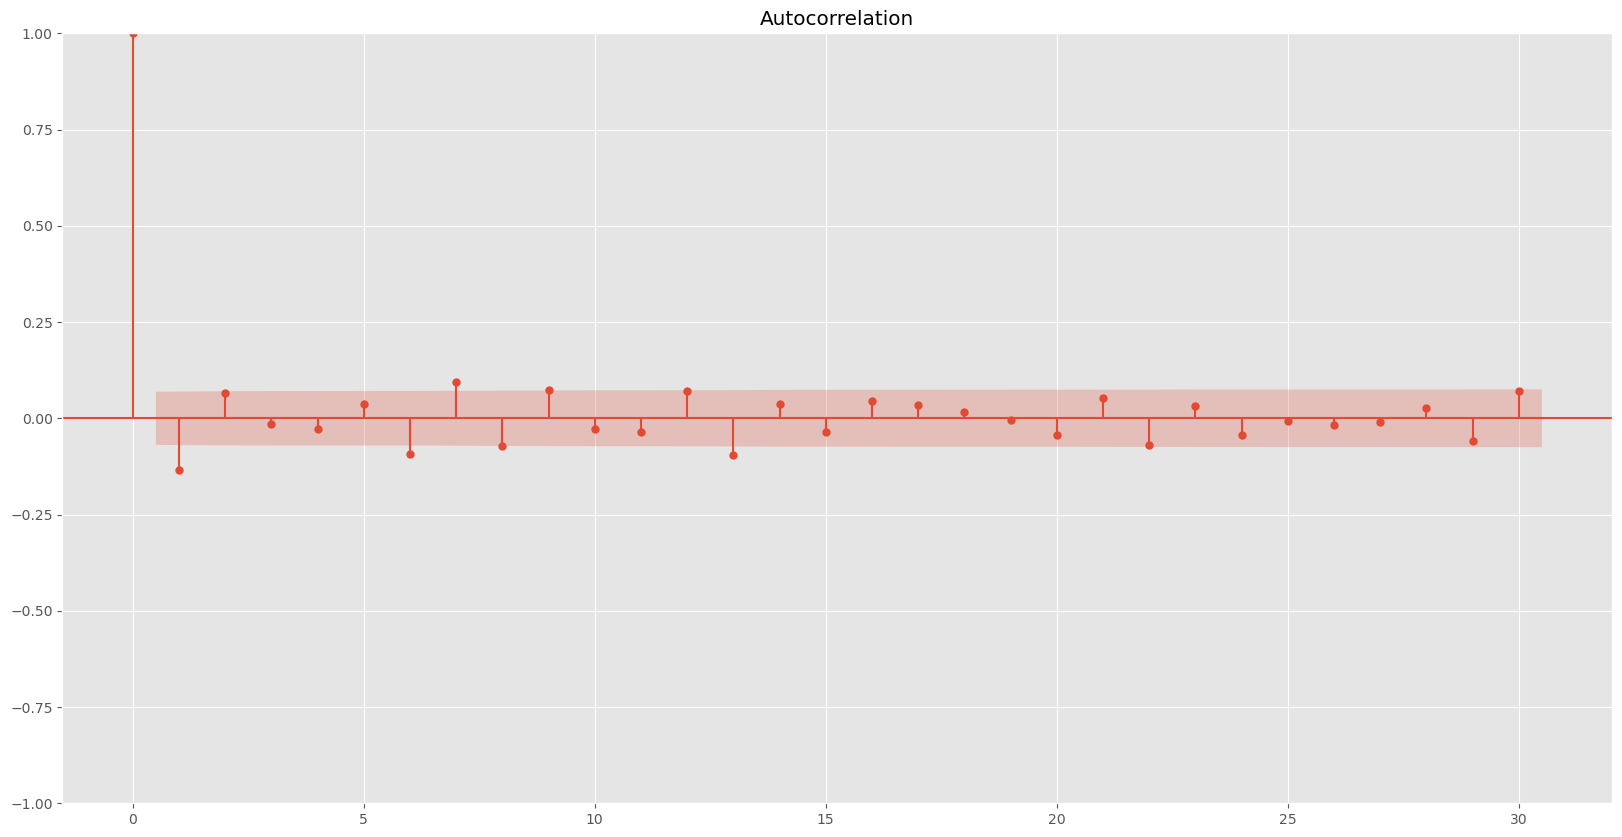

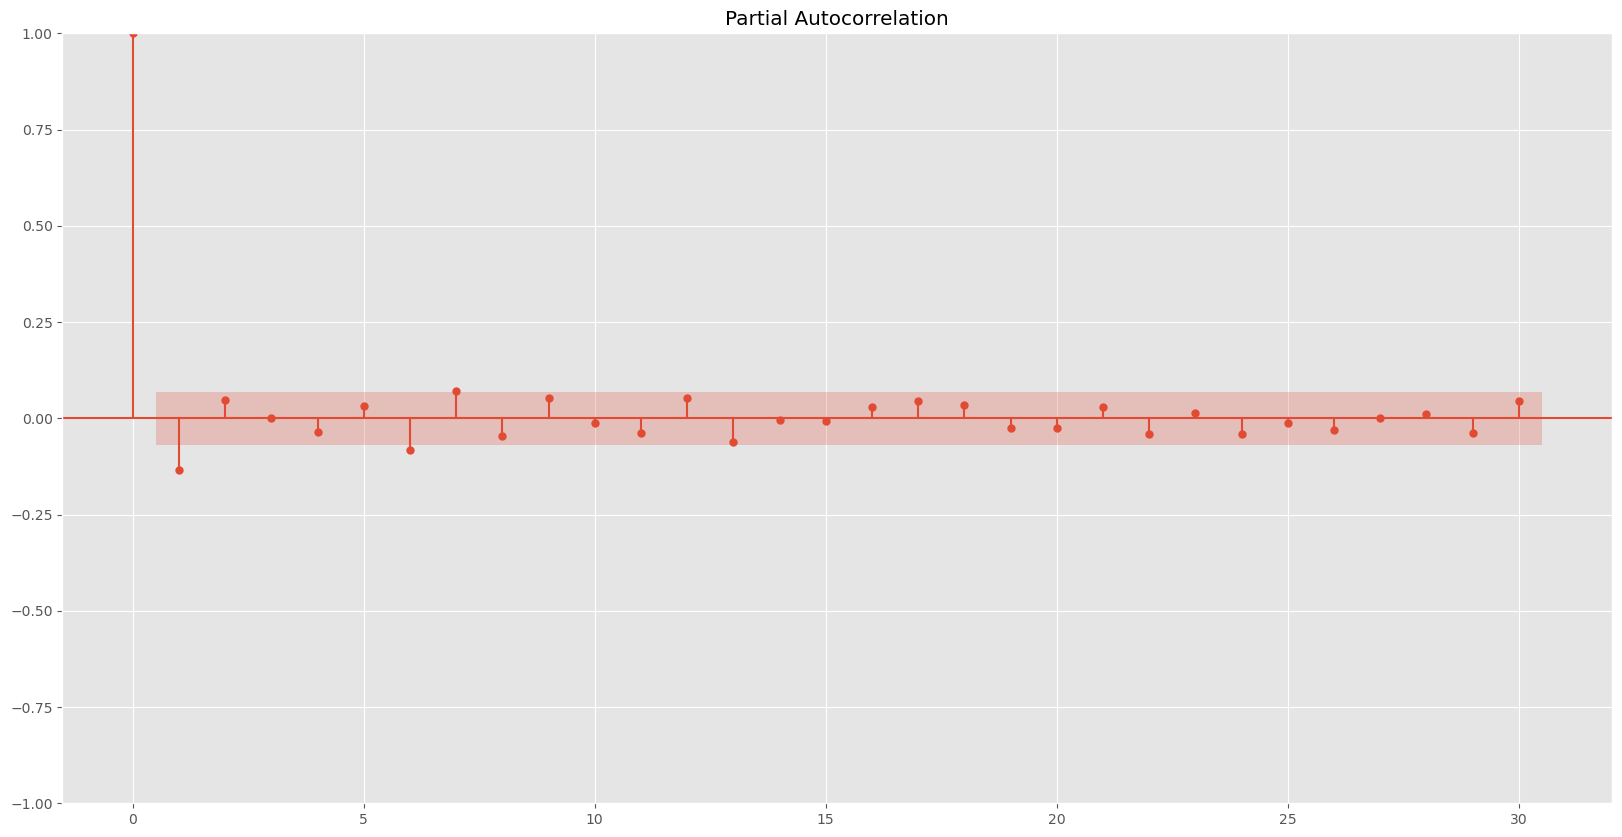

In [28]:
# Plot autocorrelation and partial autocorrelation after first order differencing 
acf_diff = plot_acf(df_train_diff)

pacf_diff = plot_pacf(df_train_diff)

In [29]:
# Conduct the Augmented Dickey Fuller Test again on the data obtained from first order differencing 
# Check the p-value again 
adf_test = adfuller(df_train_diff)
print(f'p-value: {adf_test[1]}')
# The p-value obtained after first order differencing has dropped beyond the acceptable threshold 
# Thus, consider order of differencing as 1

p-value: 4.473148324815896e-12


In [30]:
#Install and import relevant libraries for the auto ARIMA algorithm 
! pip install pmdarima
import pmdarima as pm
# Use the auto ARIMA algorithm to automatically select the optimal parameters for the ARIMA model 
auto_arima = pm.auto_arima(df, stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True)

In [31]:
# Based on the auto ARIMA model, optimal values of p, d, and q are 2, 1, and 2 respectively
# For the AIC to be as low as possible 
# Summary of auto ARIMA 
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1008
Model:               SARIMAX(2, 1, 2)   Log Likelihood                1981.572
Date:                Tue, 24 Oct 2023   AIC                          -3951.143
Time:                        22:57:26   BIC                          -3921.655
Sample:                             0   HQIC                         -3939.939
                               - 1008                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0021      0.003     -0.630      0.528      -0.008       0.004
ar.L1         -1.4193      0.218     -6.496      0.000      -1.847      -0.991
ar.L2         -0.6717      0.149     -4.503      0.000      -0.964      -0.379
ma.L1          1.3464      0.218      6.167      0.000       0.918       1.774
ma.L2          0.6472      0.131      4.957      0.000       0.391       0.903
sigma2         0.0011   3.17e-05     34.330      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):               559.38
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               1.30   Skew:                            -0.58
Prob(H) (two-sided):                  0.02   Kurtosis:                         6.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [34]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_train, order=(2,1,2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  806
Model:                 ARIMA(2, 1, 2)   Log Likelihood                1635.868
Date:                Tue, 24 Oct 2023   AIC                          -3261.737
Time:                        22:59:23   BIC                          -3238.283
Sample:                             0   HQIC                         -3252.730
                                - 806                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7198      0.049    -35.162      0.000      -1.816      -1.624
ar.L2         -0.9017      0.048    -18.614      0.000      -0.997      -0.807
ma.L1          1.6340      0.059     27.474      0.0

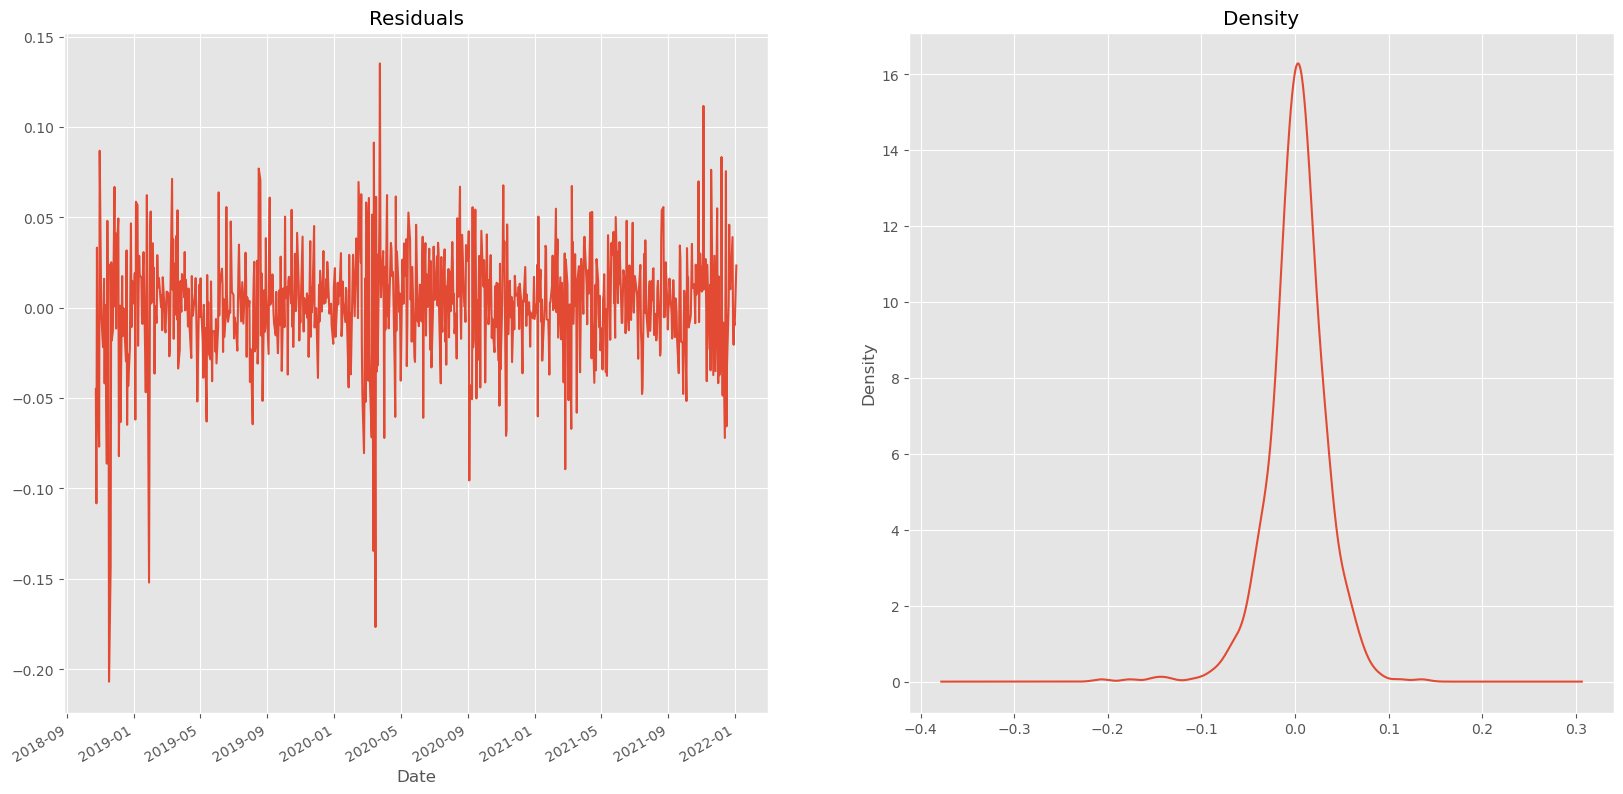

In [36]:
# Conduct residual analysis 
# To evaluate how well the model has captured characteristics of the data 
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

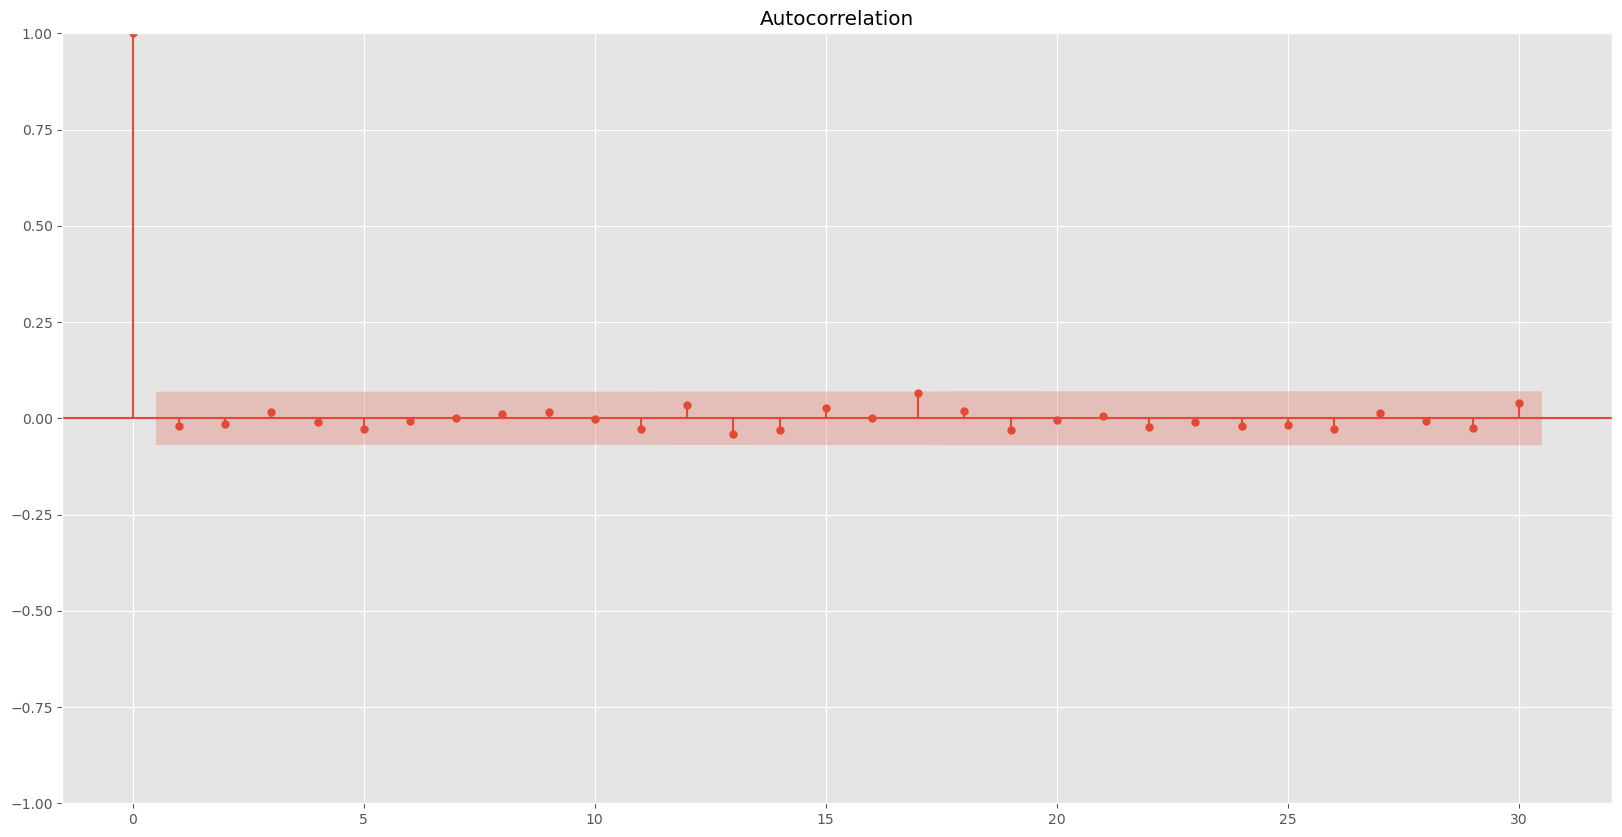

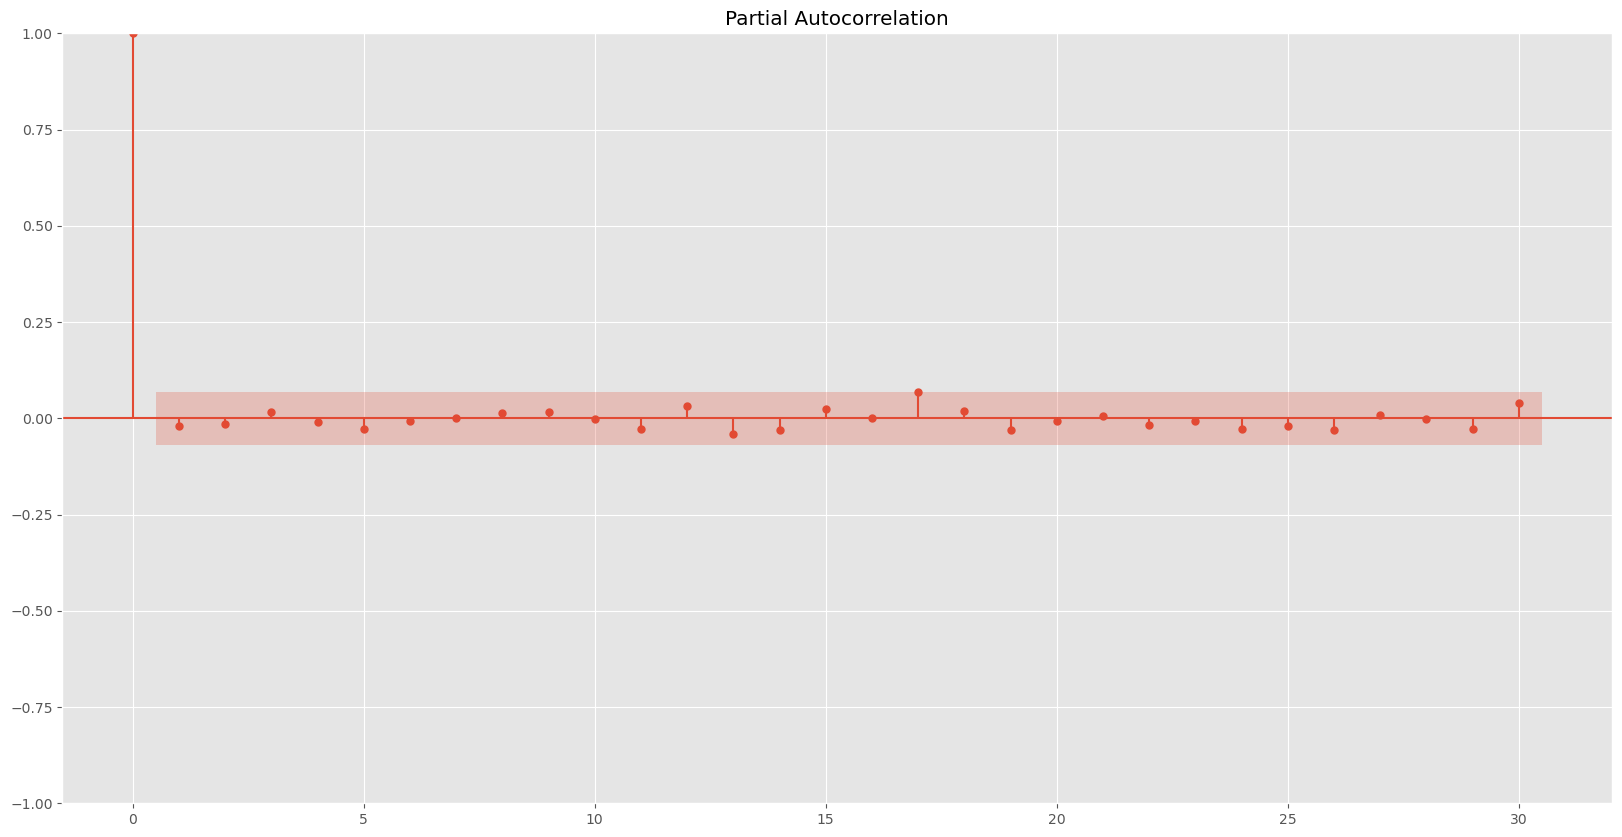

In [37]:
# Plot the autocorrelation and partial autocorrelation graph of the residuals
acf_res = plot_acf(residuals)

pacf_res = plot_pacf(residuals)

<Axes: xlabel='Date'>

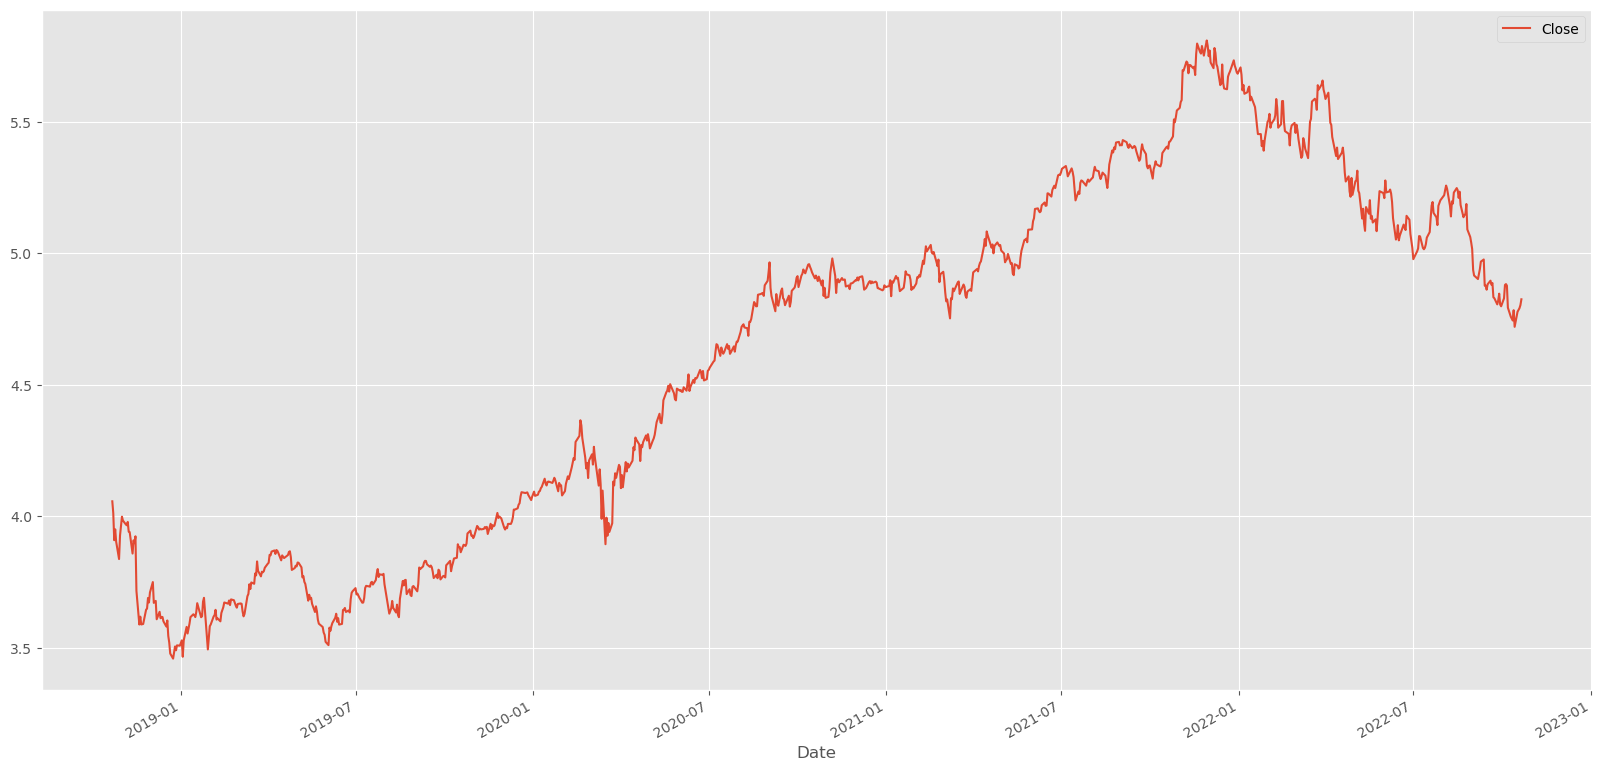

In [38]:
prediction_test = model_fit.forecast(202)

df.plot()